<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Hyperparameter_optimization_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Optimization of hyperparameter

In [182]:
!pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [184]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_labels = df_train.Histology

In [0]:
test_labels = df_test.Histology

##Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in train_labels]

In [0]:
test_labels_dec = [word_index[label] for label in test_labels]

In [0]:
from keras.utils.np_utils import to_categorical

In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.9, svd_solver='full')

In [203]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [205]:
train_data_stand_pca.shape

(131, 9)

#Building Network

In [0]:
from tensorflow import keras

In [0]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import sequence

In [0]:
from tensorflow.keras import layers

In [0]:
from tensorflow.keras import regularizers

In [0]:
from tensorflow.keras.optimizers import SGD

In [0]:
from kerastuner.tuners import RandomSearch

In [0]:
def build_model(hp):
  model = keras.models.Sequential()

#  model.add(layers.Dense(units=(hp.Int('units', min_value=3, max_value=8, step=1)), 
#                         activation='relu', input_shape=(9,)))

  model.add(layers.Dense(6, activation='relu', input_shape=(9,)))
  model.add(layers.Dense(3, activation='softmax'))
#  sgd = SGD(lr=0.001, decay=1e-6, momentum=0.5, nesterov=True)
  lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
  momentum = hp.Choice('momentum', [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
  model.compile(optimizer=SGD(learning_rate=lr, momentum=momentum), 
                loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [214]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_pca, train_labels_dec)

5

In [215]:
for train_index, test_index in skf.split(train_data_stand_pca, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   4   5   6   8   9  10  11  12  14  15  16  17  19  20  22  23
  24  25  27  28  29  30  31  32  33  34  36  37  38  39  40  41  42  44
  45  46  48  49  51  52  53  55  56  57  58  59  60  62  63  64  65  66
  67  69  71  72  75  76  77  78  79  80  81  83  84  85  86  87  88  89
  90  92  94  95  96  97  98 100 101 102 103 104 105 107 109 110 111 113
 115 116 117 119 120 121 122 124 125 126 127 128 129] TEST: [  2   3   7  13  18  21  26  35  43  47  50  54  61  68  70  73  74  82
  91  93  99 106 108 112 114 118 123 130]
TRAIN: [  0   1   2   3   5   7   8   9  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  29  30  33  34  35  36  37  38  39  40  41
  43  44  45  46  47  48  50  51  52  53  54  56  57  58  59  60  61  62
  63  65  66  68  70  73  74  76  77  78  79  80  82  83  84  85  87  88
  89  90  91  92  93  96  97  98  99 100 101 102 105 106 107 108 109 110
 111 112 113 114 115 117 118 120 122 123 124 125 127 128 130] TEST: [  4   6  10 

In [216]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical

In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

#Keras tuner RandomSearch

In [219]:
num_epochs = 30
#all_acc_histories = []
#all_loss_histories = []
#all_val_acc_histories = []
#all_val_loss_histories = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  tuner = RandomSearch(build_model, objective='val_acc', max_trials=10, 
                       executions_per_trial=3, directory='/content/my_dir', project_name='helloworld')
  
  tuner.search_space_summary()

  tuner.search(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=10)
  

#  acc_history = history.history['acc']
#  all_acc_histories.append(acc_history)

#  loss_history = history.history['loss']
#  all_loss_histories.append(loss_history)

#  acc_val_history = history.history['val_acc']
#  all_val_acc_histories.append(acc_val_history)

#  loss_val_history = history.history['val_loss']
#  all_val_loss_histories.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

INFO:tensorflow:Reloading Oracle from existing project /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from existing project /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from existing project /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from existing project /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Oracle from existing project /content/my_dir/helloworld/oracle.json
INFO:tensorflow:Reloading Tuner from /content/my_dir/helloworld/tuner0.json


INFO:tensorflow:Oracle triggered exit


In [220]:
tuner.search_space_summary()


In [221]:
tuner.results_summary()

In [222]:
tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

{'learning_rate': 0.01, 'momentum': 0.9}

In [0]:
best_model = tuner.get_best_models()[0]

##Train the best model RandomSearch

In [224]:
#num_epochs = 50
all_acc_histories_RS = []
all_loss_histories_RS = []
all_val_acc_histories_RS = []
all_val_loss_histories_RS = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  history_RS = best_model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history_RS = history_RS.history['acc']
  all_acc_histories_RS.append(acc_history_RS)

  loss_history_RS = history_RS.history['loss']
  all_loss_histories_RS.append(loss_history_RS)

  acc_val_history_RS = history_RS.history['val_acc']
  all_val_acc_histories_RS.append(acc_val_history_RS)

  loss_val_history_RS = history_RS.history['val_loss']
  all_val_loss_histories_RS.append(loss_val_history_RS)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 103 samples, validate on 28 samples
Epoch 1/30
103/103 [==============================] - 0s 943us/sample - loss: 0.9163 - acc: 0.6117 - val_loss: 0.9628 - val_acc: 0.5000
Epoch 2/30
103/103 [==============================] - 0s 326us/sample - loss: 0.8893 - acc: 0.6311 - val_loss: 0.9679 - val_acc: 0.4643
Epoch 3/30
103/103 [==============================] - 0s 349us/sample - loss: 0.9056 - acc: 0.5728 - val_loss: 0.9721 - val_acc: 0.4643
Epoch 4/30
103/103 [==============================] - 0s 303us/sample - loss: 0.8784 - acc: 0.6214 - val_loss: 1.0010 - val_acc: 0.5357
Epoch 5/30
103/103 [==============================] - 0s 294us/sample - loss: 0.8752 - acc: 0.6117 - val_loss: 1.0460 - val_acc: 0.5000
Epoch 6/30
103/103 [==============================] - 0s 315us/sample - loss: 0.8521 - acc: 0.6117 - val_loss: 0.9951 - val_acc: 0.5357
Epoch 7/30
103/103 [==============================] - 0s 310us/sample - loss: 0.8516 - acc: 0.6311 - val_loss: 0.9800 - val_acc: 0.5000
Epo

In [0]:
history_dict = history_RS.history

In [226]:
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

##Plotting training and validation loss RandomSearch


In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

In [0]:
average_acc_history_RS = [np.mean([x[i] for x in all_acc_histories_RS]) for i in range(num_epochs)]
average_loss_history_RS = [np.mean([x[i] for x in all_loss_histories_RS]) for i in range(num_epochs)]
average_val_acc_history_RS = [np.mean([x[i] for x in all_val_acc_histories_RS]) for i in range(num_epochs)]
average_val_loss_history_RS = [np.mean([x[i] for x in all_val_loss_histories_RS]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche

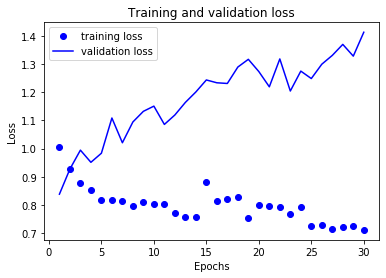

In [230]:
plt.plot(epochs, average_loss_history_RS, 'bo', label='training loss')
plt.plot(epochs, average_val_loss_history_RS, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy RandomSearch

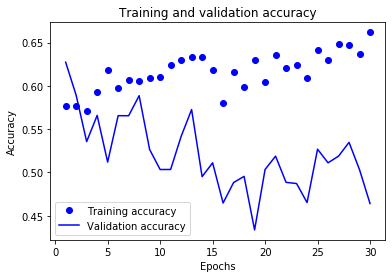

In [231]:
plt.plot(epochs, average_acc_history_RS, 'bo', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_RS, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 